# 오르면 팔고 떨어지면 사는 전략을 백테스트로 검증하기
- 전략 근거
  - 주가는 진동한다.
  - 주가에는 overshoot이 있어 적정 가격에서 벗어난 후 복귀하는 성질이 있다
- 전략
  - TOTAL_BUDGET만큼 예산을 잡는다.
  - total_amount를 days만큼 나눠서 매일 살 금액 amount를 확보한다.
  - 첫 번째 매수 : 특정 날 종가에 amount만큼 산다.
  - 매일 최대 한 번씩 매수, 매도한다.
  - 전날 종가보다 주가가 sell_percent% 오르면 amount만큼 판다.
  - 전날 종가보다 주가가 buy_percent% 내리면 amount만큼 산다.
  - 자금을 모두 사용한 경우에는
    1. 절반을 다음날 시가(or 종가)에 손절하고 전략을 이어간다.
    2. 모두 다음날 시가(or 종가)에 손절하고 전략을 이어간다.
  - profit_limit_percent만큼 이익이 발생한 경우에는 전량 매도한다.

In [1]:
from marcap import marcap_data
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from classes.Account import Account
from classes.Strategy import Strategy

df_2023 = marcap_data('2020-10-01', '2021-02-28')
df_2023.head()

,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank
Date,,,,,,,,,,,,,,,,,
2020-10-05,005930,삼성전자,KOSPI,NaN,58700,1,500,0.86,57500,59200,57500,20228289,1183456525264,350426235685000,5969782550,STK,1
2020-10-05,000660,SK하이닉스,KOSPI,NaN,83200,2,-800,-0.95,83000,84100,82300,3396894,282884127576,60569796768000,728002365,STK,2
2020-10-05,035420,NAVER,KOSPI,NaN,298500,1,2000,0.67,297500,299000,289500,906516,267077969500,49032623407500,164263395,STK,3
2020-10-05,051910,LG화학,KOSPI,NaN,659000,1,5000,0.76,670000,670000,648000,443499,291628236000,46520354037000,70592343,STK,4
2020-10-05,207940,삼성바이오로직스,KOSPI,NaN,685000,2,-5000,-0.72,697000,701000,682000,69478,47853091000,45323025000000,66165000,STK,5


In [2]:
BUDGET = 10000000 # 천만 원

yoonwoo_account = Account('윤우계좌', BUDGET)
yoonwoo_account.show_account()

이름: 윤우계좌
잔고: 10000000원
보유 주식: {}


In [3]:
STRATEGY_NAME = '윤우전략'
STRATEGY_BUDGET = BUDGET
DIVIDE_NUMBER = 5
BUY_PERCENT = -0.02
SELL_PERCENT = 0.02
PROFIT_LIMIT_PERCENT = 0.1
STOCK_NAME = '삼성전자'
DAYS = 60

yoonwoo_strategy = Strategy(STRATEGY_NAME, STRATEGY_BUDGET, DIVIDE_NUMBER,
                             BUY_PERCENT, SELL_PERCENT, PROFIT_LIMIT_PERCENT,
                               STOCK_NAME, df_2023, yoonwoo_account)

yoonwoo_strategy.show_strategy()

전략 이름: 윤우전략
전략 예산: 10000000
일별 예산: 2000000
분할 매수 횟수: 5
매수 기준 상승률: -0.02
매도 기준 하락률: 0.02
전체 익절 상한 수익률: 0.1
매매 대상 주식: 삼성전자
매매 대상 주식 데이터:               Code  Name Market Dept  Close ChangeCode  Changes  ChagesRatio  \
Date                                                                           
2020-10-05  005930  삼성전자  KOSPI  NaN  58700          1      500         0.86   
2020-10-06  005930  삼성전자  KOSPI  NaN  59000          1      300         0.51   
2020-10-07  005930  삼성전자  KOSPI  NaN  59900          1      900         1.53   

             Open   High    Low    Volume         Amount           Marcap  \
Date                                                                        
2020-10-05  57500  59200  57500  20228289  1183456525264  350426235685000   
2020-10-06  59400  59900  58700  14463826   856996117132  352217170450000   
2020-10-07  58700  59900  58500  14861838   881415107100  357589974745000   

                Stocks MarketId  Rank  
Date                                  

In [4]:
# 20일간의 삼성전자 주가 변화에 따른 매매
for i in range(DAYS):
    if i == 0:
        yoonwoo_strategy.first_buy_strategy(i)
        continue
    yoonwoo_strategy.buy_strategy(i)
    yoonwoo_strategy.sell_strategy(i)


Exception: 잔액이 부족합니다.

In [101]:
yoonwoo_account.show_account()

이름: 윤우계좌
잔고: 3174325.75원
보유 주식: {'삼성전자': {'count': 458, 'purchase_amount': 26818190}}


In [102]:
open, close, high, low = yoonwoo_strategy._get_now_price_data(60 - 1)
yoonwoo_account.get_earning_rate(STOCK_NAME, close)

0.33720433780206643

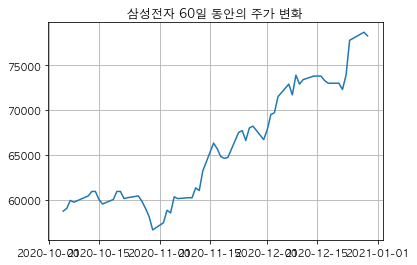

In [103]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')

plt.plot(samsung.head(60)['Close'])
plt.title(f'{STOCK_NAME} {DAYS}일 동안의 주가 변화')
plt.grid()
plt.show()